# **Hand Gesture Recogntion using CNN (Accuracy 98%)**

# **Task-4**
**Develop a hand gesture recognition model that can accurately identify and classify different hand gestures from image or video data, enabling intuitive human-computer interaction and gesture-based control systems.**

Dataset: https://www.kaggle.com/gti-upm/leapgestrecog

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout 
from keras.utils import plot_model
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

2024-07-01 16:50:23.410777: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 16:50:23.410971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 16:50:23.578810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Read Images and Labels in the Dataset**

In [2]:
images=[]
labels=[]

for directory in os.listdir('/kaggle/input/leapgestrecog/leapGestRecog/'):
    for subdir in os.listdir(os.path.join('/kaggle/input/leapgestrecog/leapGestRecog/',directory)):
        for image in os.listdir(os.path.join('/kaggle/input/leapgestrecog/leapGestRecog/',directory, subdir)):
            img_path = os.path.join('/kaggle/input/leapgestrecog/leapGestRecog/', directory, subdir, image)
            images.append(img_path)
            labels.append(subdir)

In [3]:
df = pd.DataFrame({'Image':images,'Label':labels})
df.tail()

,Image,Label
19995,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist
19996,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist
19997,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist
19998,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist
19999,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist


# **Randomly Display some labeled images from the dataset**

[[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]]


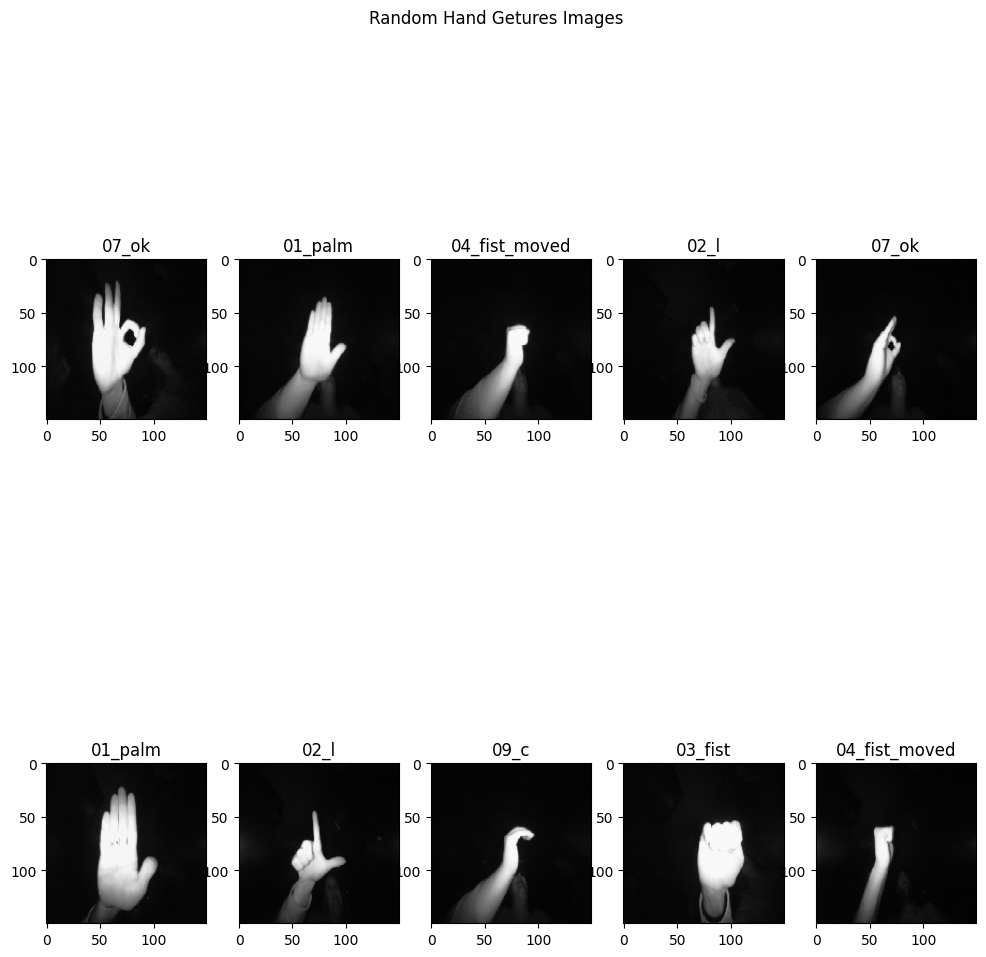

In [4]:
df_img = df['Image']
df_label = df['Label']

nrows=2
ncols = 5
fig,axx = plt.subplots(nrows,ncols, figsize=(12,12))
fig.suptitle("Random Hand Getures Images")
print(axx)

for i in range(nrows):
        for j in range(ncols):
                n = np.random.randint(0,20000)
                img = load_img(df['Image'][n],target_size=(150,150)) 
                img = img_to_array(img) 
                img = np.expand_dims(img,axis=0) 
                img /= 255.0 #scale image values between 0,1
                label = df_label[n]
                
                image = np.squeeze(img)
                axx[i][j].imshow(image)
                axx[i][j].set_title(label)
plt.show()
plt.close()

# **Split Dataset into 70% for training 15%,15% for validation and testing**

In [5]:
x_train,x = train_test_split(df, test_size = 0.3)
x_valid,x_test = train_test_split(x,test_size=0.5)
x_train.info()
x_valid.info()
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14000 entries, 3585 to 19293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   14000 non-null  object
 1   Label   14000 non-null  object
dtypes: object(2)
memory usage: 328.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 1621 to 7020
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   3000 non-null   object
 1   Label   3000 non-null   object
dtypes: object(2)
memory usage: 70.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 17718 to 6151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   3000 non-null   object
 1   Label   3000 non-null   object
dtypes: object(2)
memory usage: 70.3+ KB


# **Data Augmentation**

In [6]:
datagen = ImageDataGenerator(
        rotation_range=10, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, 
        brightness_range=[0.2,1.2]) 


train_datagen = ImageDataGenerator(rescale=1.0/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)
validate_datagen = ImageDataGenerator(rescale=1.0/255)

In [7]:
b_size =1
train_generator = train_datagen.flow_from_dataframe(dataframe=x_train,x_col="Image",y_col='Label',class_mode="categorical",target_size=(150,150),batch_size=b_size,seed=2020, shuffle=True)
valid_generator = validate_datagen.flow_from_dataframe(dataframe=x_valid,x_col="Image",y_col='Label',class_mode="categorical",target_size=(150,150),batch_size=b_size,seed=2020, shuffle=False)

Found 14000 validated image filenames belonging to 10 classes.
Found 3000 validated image filenames belonging to 10 classes.


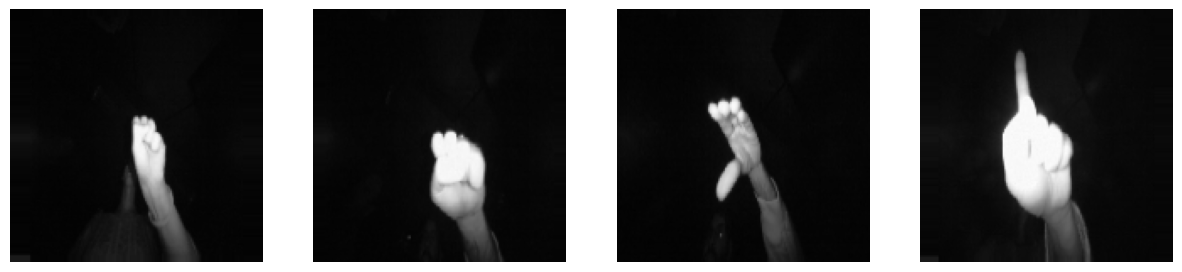

In [8]:
fig,axx = plt.subplots(nrows=1,ncols=4, figsize=(15,15))

for i in range(4):
    image = next(train_generator)[0].astype('float64')
    image = np.squeeze(image)
    axx[i].imshow(image)
    axx[i].axis('off')

# **Build Convolutional Neural Network Model (CNN)**

In [9]:
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
             optimizer = 'adam',
             metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 72, 72, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,213,098 (4.63 MB)

 Trainable params: 1,213,098 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

# **Visualize Model**

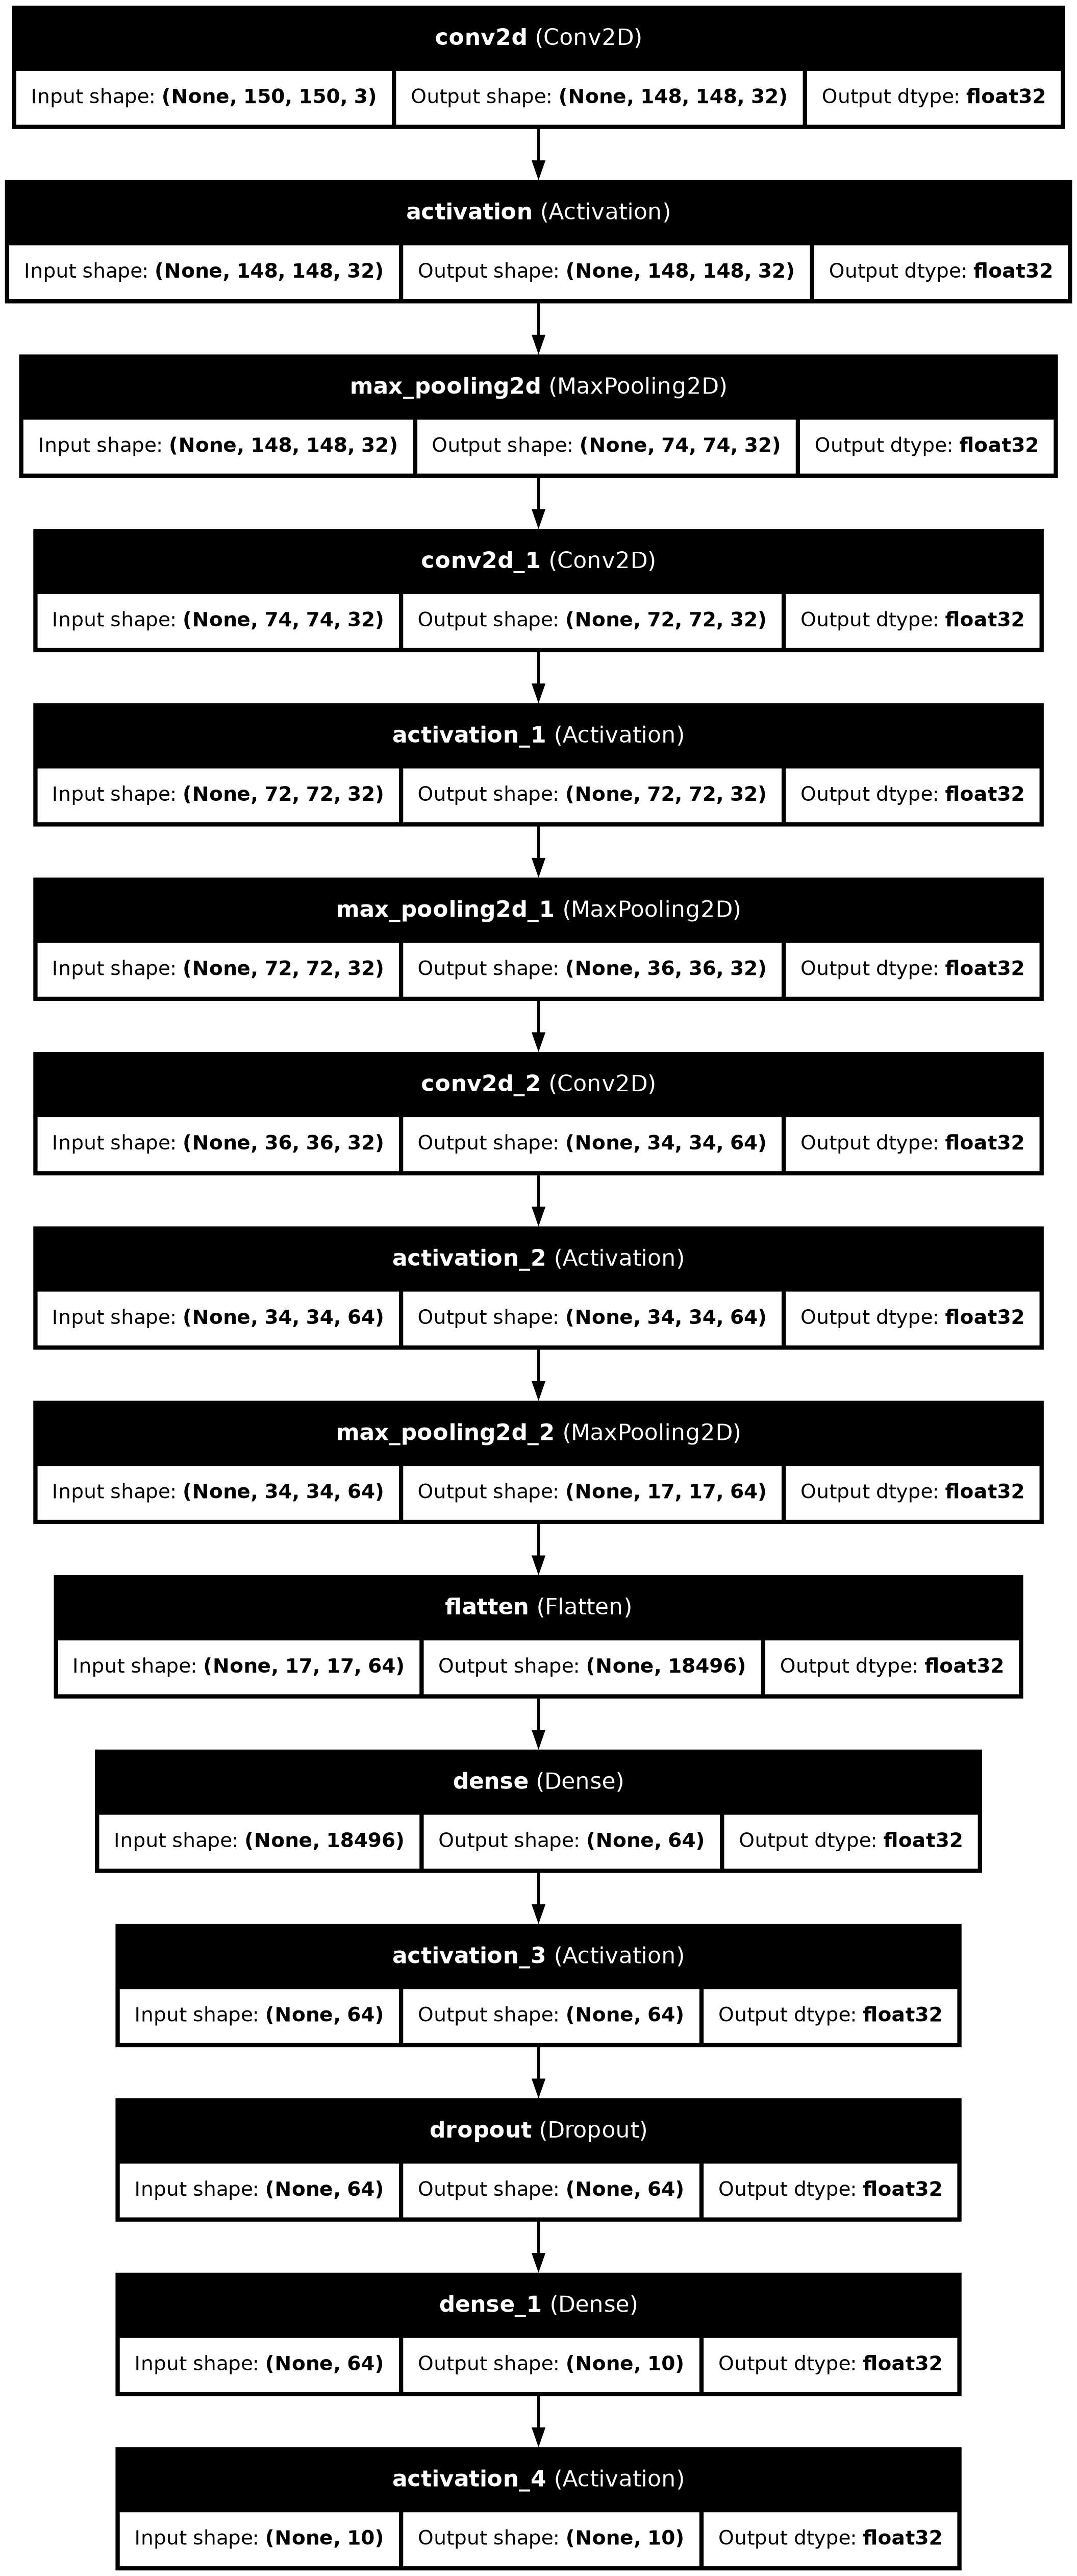

In [10]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True 
)

# **Train and save Model**

In [11]:
history = model.fit(train_generator,
                   steps_per_epoch=2000//b_size,
                   epochs = 20,
                   validation_data = valid_generator,
                    validation_steps=800//b_size)
                   
model.save('handG_R.h5')

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 66s 32ms/step - categorical_accuracy: 0.2178 - loss: 2.0674 - val_categorical_accuracy: 0.8425 - val_loss: 0.5735
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 63s 32ms/step - categorical_accuracy: 0.7767 - loss: 0.6924 - val_categorical_accuracy: 0.9287 - val_loss: 0.2290
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - categorical_accuracy: 0.8708 - loss: 0.3753 - val_categorical_accuracy: 0.9588 - val_loss: 0.1266
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - categorical_accuracy: 0.9177 - loss: 0.2588 - val_categorical_accuracy: 0.9883 - val_loss: 0.0519
Epoch 5/20
   7/2000 ━━━━━━━━━━━━━━━━━━━━ 54s 27ms/step - categorical_accuracy: 0.9796 - loss: 0.2783

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - categorical_accuracy: 0.9324 - loss: 0.2392 - val_categorical_accuracy: 0.9625 - val_loss: 0.1010
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - categorical_accuracy: 0.9424 - loss: 0.1868 - val_categorical_accuracy: 0.9950 - val_loss: 0.0254
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 63s 31ms/step - categorical_accuracy: 0.9406 - loss: 0.1539 - val_categorical_accuracy: 0.9912 - val_loss: 0.0340
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_categorical_accuracy: 0.9867 - val_loss: 0.0375
Epoch 9/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - categorical_accuracy: 0.9522 - loss: 0.1593 - val_categorical_accuracy: 0.9937 - val_loss: 0.0348
Epoch 10/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 63s 31ms/step - categorical_accuracy: 0.9634 - loss: 0.1075 - val_categorical_accuracy: 0.9975 - val_loss: 0.0180
Epoch 11/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 61s 30ms/step - categoric

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000/2000 ━━━━━━━━━━━━━━━━━━━━ 61s 31ms/step - categorical_accuracy: 0.9681 - loss: 0.1141 - val_categorical_accuracy: 0.9925 - val_loss: 0.0268
Epoch 14/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - categorical_accuracy: 0.9607 - loss: 0.1068 - val_categorical_accuracy: 0.9987 - val_loss: 0.0050
Epoch 15/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 61s 31ms/step - categorical_accuracy: 0.9614 - loss: 0.1561 - val_categorical_accuracy: 0.9925 - val_loss: 0.0237
Epoch 16/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_categorical_accuracy: 1.0000 - val_loss: 0.0155
Epoch 17/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 61s 30ms/step - categorical_accuracy: 0.9757 - loss: 0.0802 - val_categorical_accuracy: 0.9975 - val_loss: 0.0102
Epoch 18/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - categorical_accuracy: 0.9797 - loss: 0.0564 - val_categorical_accuracy: 0.9975 - val_loss: 0.0047
Epoch 19/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - categ

In [12]:
history.history


{'categorical_accuracy': [0.4154999852180481,
  0.8090000152587891,
  0.8805000185966492,
  0.9100000262260437,
  0.934499979019165,
  0.9380000233650208,
  0.9424999952316284,
  0.0,
  0.9555000066757202,
  0.9574999809265137,
  0.9514999985694885,
  0.9664999842643738,
  0.9670000076293945,
  0.9735000133514404,
  0.965499997138977,
  0.0,
  0.9785000085830688,
  0.9810000061988831,
  0.9785000085830688,
  0.9865000247955322],
 'loss': [1.6340177059173584,
  0.6113220453262329,
  0.3652943968772888,
  0.27361229062080383,
  0.18624809384346008,
  0.18230900168418884,
  0.16025498509407043,
  0.0,
  0.1497345268726349,
  0.1378956139087677,
  0.14682433009147644,
  0.10085723549127579,
  0.11870637536048889,
  0.08129887282848358,
  0.13013967871665955,
  0.0,
  0.07333710789680481,
  0.06263823807239532,
  0.06321077048778534,
  0.059407878667116165],
 'val_categorical_accuracy': [0.8424999713897705,
  0.9287499785423279,
  0.9587500095367432,
  0.9883333444595337,
  0.96249997615814

# **Visualize training&validation loss**

In [13]:
fig = go.Figure()
epochs = 20
fig.add_trace(go.Scatter(x=np.arange(0,epochs,1),
y=history.history['loss'],
mode='lines',
name=f'training loss',
marker_size=3,
line_color='blue'))
fig.add_trace(go.Scatter(x=np.arange(0, epochs, 1),
                         y=history.history['val_loss'],
                         mode='lines',
                         name=f'Validation loss',
                         line_color='grey'))
fig.update_layout(
                  title="CNN training loss",
                  xaxis_title="Epochs",
                  yaxis_title=f"CategoricalCrossentropy")
                  
fig.update_layout({'plot_bgcolor': '#f2f8fd' , 
                   'paper_bgcolor': 'white',}, 
                   template='plotly_white')

# **Visualize training&validation accuracy**

In [14]:
fig = go.Figure()
epochs = 20
fig.add_trace(go.Scatter(x=np.arange(0,epochs,1),
y=history.history['categorical_accuracy'],
mode='lines',
name=f'training accuracy',
marker_size=3,
line_color='blue'))
fig.add_trace(go.Scatter(x=np.arange(0, epochs, 1),
                         y=history.history['val_categorical_accuracy'],
                         mode='lines',
                         name=f'Validation accuracy',
                         line_color='grey'))
fig.update_layout(
                  title="CNN training accuracy",
                  xaxis_title="Epochs",
                  yaxis_title=f"CategoricalCrossentropy")
                  
fig.update_layout({'plot_bgcolor': '#f2f8fd' , 
                   'paper_bgcolor': 'white',}, 
                   template='plotly_white')

# **Test Model to new data**

In [15]:
x_test.info()
x_test.tail(20)
samples= x_test.sample(n=5)

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 17718 to 6151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   3000 non-null   object
 1   Label   3000 non-null   object
dtypes: object(2)
memory usage: 70.3+ KB


In [16]:
model = load_model('./handG_R.h5',compile=True)
